In [52]:
%pip install pandas numpy matplotlib seaborn scikit-learn tensorflow keras cartopy

Note: you may need to restart the kernel to use updated packages.


In [53]:
%pip install kaggle kagglehub

Note: you may need to restart the kernel to use updated packages.


## Data Import

### We need to use Kaggle's API to download the data since it's too big to be uploaded to GitHub

In [54]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("usdot/flight-delays")

print("Path to dataset files:", path)

Path to dataset files: /Users/naominayman/.cache/kagglehub/datasets/usdot/flight-delays/versions/1


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.compose import ColumnTransformer
from scipy.stats import pointbiserialr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from collections import OrderedDict


In [56]:
import tensorflow as tf
from tensorflow import keras
# could be cool to do sometype of simple NN 

In [57]:
df = pd.read_csv(path + "/flights.csv")
airports = pd.read_csv(path + "/airports.csv")

/var/folders/78/46rnh6cd7w1dzd2t3dyd5t040000gn/T/ipykernel_52217/1086104120.py:1: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + "/flights.csv")


In [58]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

In [59]:
df.DEPARTURE_DELAY = df.DEPARTURE_DELAY.dropna() # drop NaN
df.ARRIVAL_DELAY = df.ARRIVAL_DELAY.dropna() # drop NaN

In [60]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### We need to decide how long the departure/arrival delay needs to be to classify as a significant delay

This is just my data exploration

In [61]:
df.DEPARTURE_DELAY.describe(), df.ARRIVAL_DELAY.describe()

(count    5.732926e+06
 mean     9.370158e+00
 std      3.708094e+01
 min     -8.200000e+01
 25%     -5.000000e+00
 50%     -2.000000e+00
 75%      7.000000e+00
 max      1.988000e+03
 Name: DEPARTURE_DELAY, dtype: float64,
 count    5.714008e+06
 mean     4.407057e+00
 std      3.927130e+01
 min     -8.700000e+01
 25%     -1.300000e+01
 50%     -5.000000e+00
 75%      8.000000e+00
 max      1.971000e+03
 Name: ARRIVAL_DELAY, dtype: float64)

In [62]:
df.DEPARTURE_DELAY.value_counts().sort_index()

DEPARTURE_DELAY
-82.0      1
-68.0      1
-61.0      1
-56.0      1
-55.0      1
          ..
 1631.0    1
 1649.0    1
 1670.0    1
 1878.0    1
 1988.0    1
Name: count, Length: 1217, dtype: int64

In [63]:
df.ARRIVAL_DELAY.value_counts().sort_index()

ARRIVAL_DELAY
-87.0      2
-82.0      1
-81.0      2
-80.0      3
-79.0      2
          ..
 1636.0    2
 1638.0    1
 1665.0    1
 1898.0    1
 1971.0    1
Name: count, Length: 1240, dtype: int64

In [64]:
len(df.columns)

31

## Plot airports on a map and maybe cluster based on geographic location

In [65]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


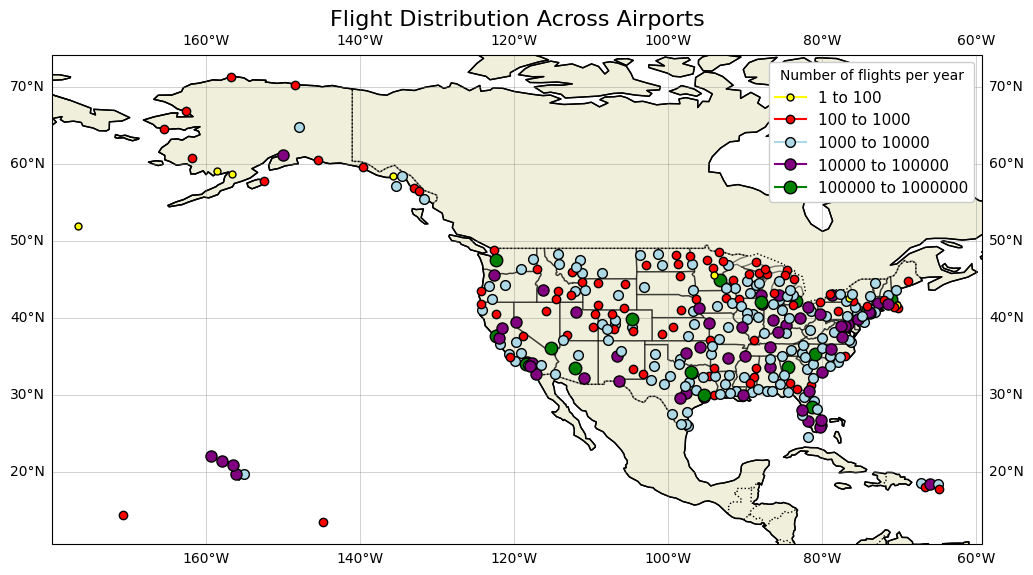

In [66]:
count_flights = df['ORIGIN_AIRPORT'].value_counts()
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []

for i in range(len(size_limits)-1):
    labels.append(f"{size_limits[i]} to {size_limits[i+1]}")

# Create a figure with a geographic projection
plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.STATES, linestyle='-', alpha=0.5)

ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5)

# Plot airports on the map
for index, (code, y, x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    isize = [i for i, val in enumerate(size_limits) if val < count_flights.get(code, 0)]
    if isize:  # Check if the airport has flight counts within defined limits
        ind = isize[-1]
        ax.plot(x, y, marker='o', markersize=ind+5, markeredgewidth=1, 
                color=colors[ind], markeredgecolor='k', 
                transform=ccrs.PlateCarree(), label=labels[ind])


handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 to 100', '100 to 1000', '1000 to 10000',
             '10000 to 100000', '100000 to 1000000')
new_label = OrderedDict()
for key in key_order:
    if key in by_label:
        new_label[key] = by_label[key]

# Add a legend
plt.legend(new_label.values(), new_label.keys(), loc='upper right', prop={'size':11},
           title='Number of flights per year', frameon=True, framealpha=1)

# Show the map
plt.title("Flight Distribution Across Airports", fontsize=16)
plt.show()

## Airport location grouping by west coast, midwest, east coast, south


In [67]:
#joining on origin airport
df = df.join(airports.set_index('IATA_CODE'), on='ORIGIN_AIRPORT', how='inner')


In [68]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,NaN,NaN,NaN,Ted Stevens Anchorage International Airport,Anchorage,AK,USA,61.17432,-149.99619
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,NaN,NaN,NaN,NaN,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,NaN,NaN,NaN,NaN,San Francisco International Airport,San Francisco,CA,USA,37.61900,-122.37484
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,NaN,NaN,NaN,NaN,Los Angeles International Airport,Los Angeles,CA,USA,33.94254,-118.40807
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,NaN,NaN,NaN,NaN,Seattle-Tacoma International Airport,Seattle,WA,USA,47.44898,-122.30931


In [69]:
def group_states(row):
    if row in ['CA', 'WA', 'OR', 'AK', 'HI', 'AZ', 'NV', 'UT', 'ID', 'MT', 'WY', 'CO', 'NM']:
        return 'west'
    elif row in ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'IN', 'MI', 'OH']:
        return 'midwest'
    elif row in ['TX', 'OK', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL', 'SC', 'NC', 'TN', 'KY']:
        return 'south'
    elif row in ['PA', 'NY', 'NJ', 'CT', 'RI', 'MA', 'NH', 'VT', 'ME', 'DE', 'MD', 'VA', 'WV', 'DC']:
        return 'east'
    else:
        return 'Other'

In [70]:
# group origin airport states into regions
df['OA_grouped'] = df['STATE'].map(group_states)

In [71]:
#remove join on airports and origin airport
df.drop(['AIRPORT', 'CITY','STATE', 'COUNTRY', 'LATITUDE', "LONGITUDE"], axis=1, inplace=True)

In [72]:
#now join on destination airport
df = df.join(airports.set_index('IATA_CODE'), on='DESTINATION_AIRPORT', how='inner')

In [73]:
# map destination airport states into regions
df['DA_grouped'] = df['STATE'].map(group_states)

In [74]:
# remove airport information since we don't need it anymore
df.drop(['AIRPORT', 'CITY','STATE', 'COUNTRY', 'LATITUDE', "LONGITUDE"], axis=1, inplace=True)

In [75]:
# now we have grouped airport regions so one hot encoding them will be much easier
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,OA_grouped,DA_grouped
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,west
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,south
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,south
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,south
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,west,west


## Create the target variable by classifying significant delay as a delay that lasts longer than 10 mins

In [92]:
# create the target variable
df['target'] = (
    (df['ARRIVAL_DELAY'] > 0) |
    (df['DEPARTURE_DELAY'] > 0) |
    (df['CANCELLED'] == 1) |
    (df['DIVERTED'] == 1) |
    (df['AIR_SYSTEM_DELAY'] > 0) |
    (df['SECURITY_DELAY'] > 0) |
    (df['AIRLINE_DELAY'] > 0) |
    (df['LATE_AIRCRAFT_DELAY'] > 0) |
    (df['WEATHER_DELAY'] > 0))

df.target = df.target.astype(int)

In [ ]:
# The target variable classes are more or less balanced so we don't need to worry about class imbalance
df.target.value_counts()

target
0    2730045
1    2602869
Name: count, dtype: int64

## Feature selection and correlation testing

### Feature handling/scaling

In [96]:
# Month, Day, Day of Week, and Scheduled Departure are cyclic features, need to create sin and cos features

def calc_sin(feature):
    return np.sin(2 * np.pi * feature) 

def calc_cos(feature):
    return np.cos(2 * np.pi * feature)

In [97]:
df['month_sin'] = calc_sin((df.MONTH - 1) / 12)
df['month_cos'] = calc_cos((df.MONTH - 1) / 12)
df['day_sin'] = calc_sin((df.DAY - 1) / 31)
df['day_cos'] = calc_cos((df.DAY - 1) / 31)
df['dow_sin'] = calc_sin((df.DAY_OF_WEEK - 1) / 7)
df['dow_cos'] = calc_cos((df.DAY_OF_WEEK - 1) / 7)
df['hour_sin'] = calc_sin((df.SCHEDULED_DEPARTURE) / 24)
df['hour_cos'] = calc_cos((df.SCHEDULED_DEPARTURE) / 24)

In [98]:
features = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos', 'AIRLINE', 'OA_grouped', 'DA_grouped']
cat_features = ['AIRLINE', 'OA_grouped', 'DA_grouped']
num_features = ['month_sin', 'month_cos', 'day_sin', 'day_cos', 'dow_sin', 'dow_cos', 'hour_sin', 'hour_cos']

### Categorical Feature Correlation Testing - Chi-Squared

In [99]:
# one hot encode the categorical variables and drop numeric values just for correlation testing
ct = ColumnTransformer([('OHE', OneHotEncoder(), ['AIRLINE', 'OA_grouped', 'DA_grouped'])], remainder='drop')

# we'll sample the data to make it faster to work with
df_sample = df.sample(frac=0.3, replace=False, random_state=42)

chi_features_ohe = ct.fit_transform(df_sample[features])

In [100]:
chi2_stats, p_values = chi2(chi_features_ohe, df_sample['target'])

chi2_results = pd.DataFrame({
    'Feature': ct.get_feature_names_out(),
    'Chi2 Statistic': chi2_stats,
    'P-Value': p_values
})

chi2_results

,Feature,Chi2 Statistic,P-Value
0,OHE__AIRLINE_AA,235.171027,4.443048e-53
1,OHE__AIRLINE_AS,1192.241213,2.961451e-261
2,OHE__AIRLINE_B6,23.751315,1.096204e-06
3,OHE__AIRLINE_DL,4229.286046,0.000000e+00
4,OHE__AIRLINE_EV,394.452598,8.882909e-88
5,OHE__AIRLINE_F9,256.733523,8.841932e-58
6,OHE__AIRLINE_HA,258.353810,3.920582e-58
7,OHE__AIRLINE_MQ,25.384372,4.697080e-07
8,OHE__AIRLINE_NK,1300.173273,1.036494e-284
9,OHE__AIRLINE_OO,751.691523,1.720299e-165


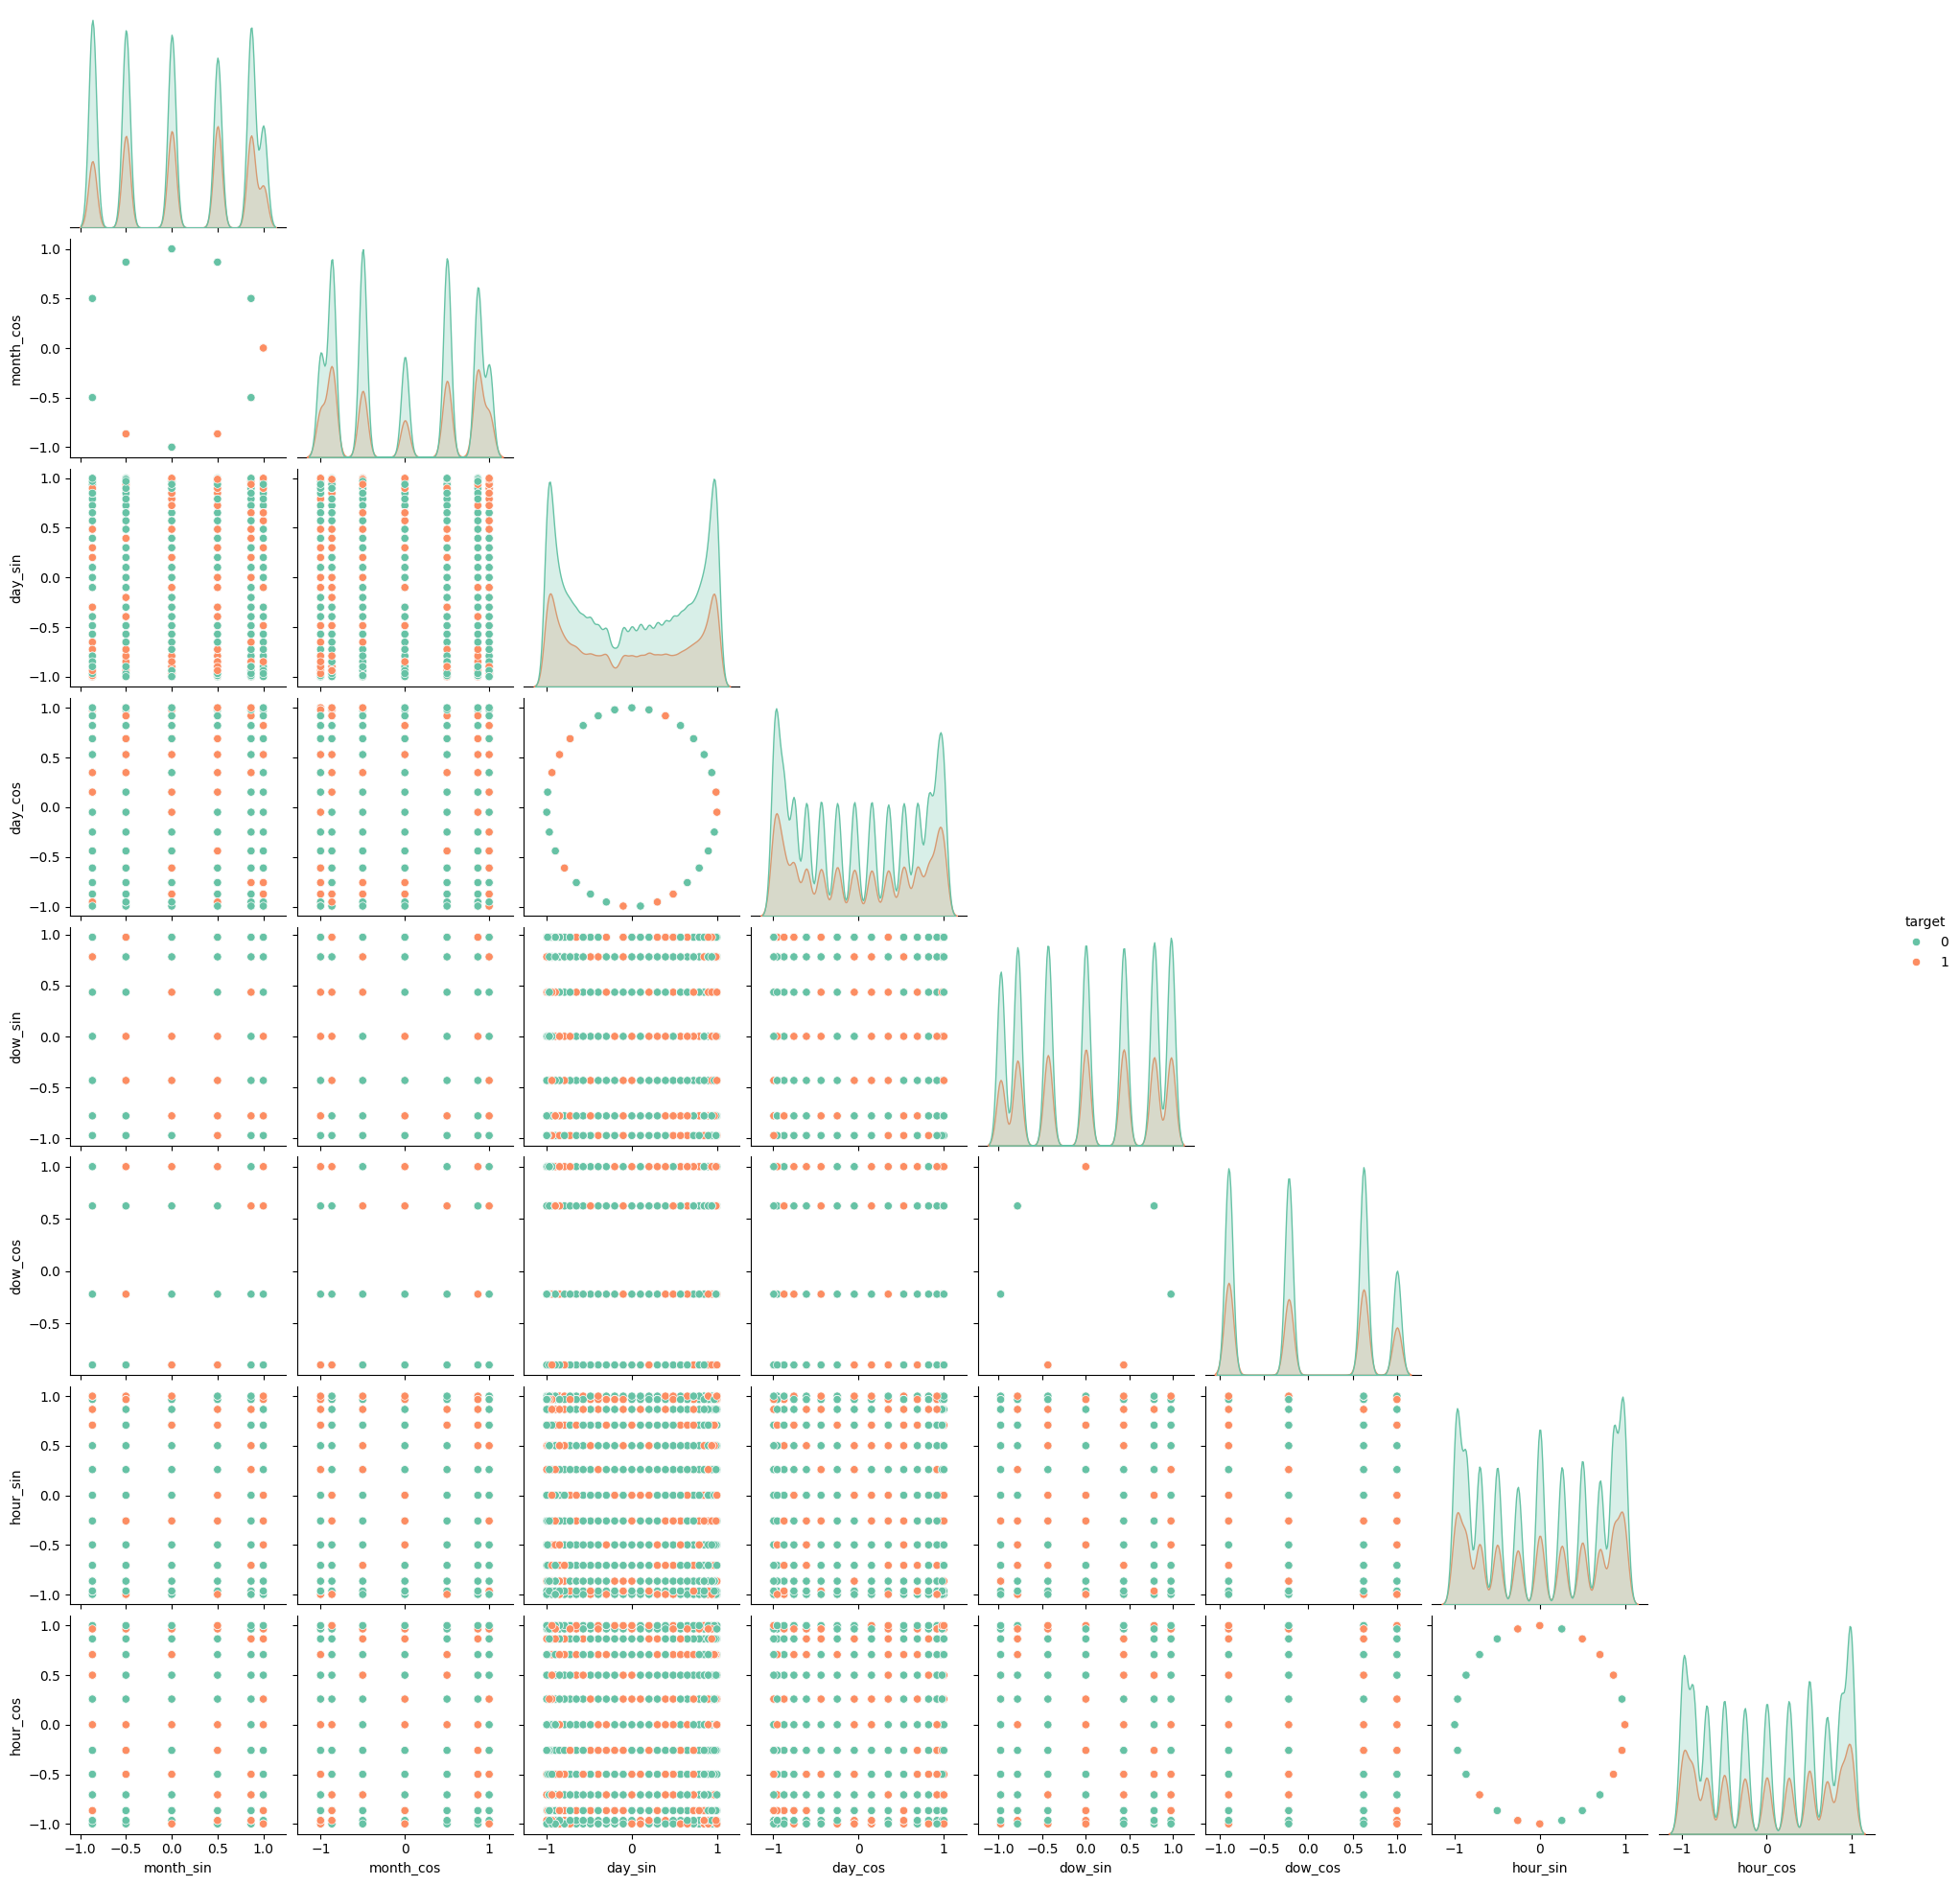

In [82]:
####### DO NOT RUN THIS CELLLLLLLLLL ########
df_numeric = df_sample[num_features + ['target']]

sns.pairplot(df_numeric, hue='target', diag_kind='kde', corner=True, palette='Set2')

plt.show()

### Point-Biserial Correlation between numerical features and binary target classification

In [101]:
correlations = {}
for feature in num_features:
    corr, p_value = pointbiserialr(df_sample[feature], df_sample['target'])
    correlations[feature] = (corr, p_value)

correlation_df = pd.DataFrame(correlations, index=['Correlation', 'P-Value']).T
correlation_df


,Correlation,P-Value
month_sin,0.044759,0.000000e+00
month_cos,0.022342,9.674237e-176
day_sin,-0.004925,4.692352e-10
day_cos,-0.007751,1.076996e-22
dow_sin,0.010931,1.747756e-43
dow_cos,-0.007790,6.642585e-23
hour_sin,-0.007033,5.804218e-19
hour_cos,-0.006802,7.712497e-18


### Mutual Information Correlation between numerical features and binary target classification

In [102]:
########## DO NOT RUN THIS CELL ##########

mutual_info = mutual_info_classif(df_sample[num_features], df_sample['target'])

mutual_info_df = pd.DataFrame({
    'Feature': num_features,
    'Mutual Information': mutual_info
}).sort_values(by='Mutual Information', ascending=False)

mutual_info_df

,Feature,Mutual Information
5,dow_cos,0.045284
1,month_cos,0.032728
0,month_sin,0.032352
4,dow_sin,0.027679
6,hour_sin,0.014871
7,hour_cos,0.012733
3,day_cos,0.009940
2,day_sin,0.006679


## Create a model and figure out the feature encoding

### Feature encoding: one hot encode categorical features, leave numerical features alone

In [103]:
# one hot encode the categorical variables
ct = ColumnTransformer([('OHE', OneHotEncoder(), ['AIRLINE', 'OA_grouped', 'DA_grouped']),
                        ('passthrough', 'passthrough', num_features)], remainder='passthrough')

features_ohe = ct.fit_transform(df_sample[features])

In [104]:
tree = DecisionTreeClassifier()

# split the data
X_train, X_test, y_train, y_test = train_test_split(features_ohe, df_sample['target'], test_size=0.2, random_state=42)

# fit the model
tree.fit(X_train, y_train)


DecisionTreeClassifier()

In [105]:
y_pred_train = tree.predict(X_train)
print(f'Train Confusion Matrix:\n {confusion_matrix(y_train, y_pred_train)}') 
print(f'Train Precision: {precision_score(y_train, y_pred_train)}')
print(f'Train Recall: {recall_score(y_train, y_pred_train)}')
print(f'Train Accuracy: {accuracy_score(y_train, y_pred_train)}')
print(f'Train F1 Score: {f1_score(y_train, y_pred_train)}')

Train Confusion Matrix:
 [[581487  73446]
 [183962 441004]]
Train Precision: 0.8572339391583245
Train Recall: 0.705644787076417
Train Accuracy: 0.7988841307009381
Train F1 Score: 0.7740877783004627


In [106]:
y_pred = tree.predict(X_test)
print(f'Test Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}') 
print(f'Test Precision: {precision_score(y_test, y_pred)}')
print(f'Test Recall: {recall_score(y_test, y_pred)}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
print(f'Test F1 Score: {f1_score(y_test, y_pred)}')

Test Confusion Matrix:
 [[106666  57519]
 [ 81788  74002]]
Test Precision: 0.5626629967837836
Test Recall: 0.4750112330701585
Test Accuracy: 0.5646316118446754
Test F1 Score: 0.5151351671185579


very high train accuracy and low test accuracy, high variance and low bias, suggesting the model is overfit

need to consider different data scaling techniques, such as one hot encoding for airlines and airports but a different method for month day scheduled departure and day of the week since they're not quite categorical or continuous 

In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,             
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation Score:", random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
